**Final Project Milestone 4**

By Daniel Alpert, Brendan Kent, and Thomas Negron

In [40]:
# import libraries
import numpy as np
import pandas as pd
import json
import ast
import subprocess
import time
import math
from collections import namedtuple
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, rmsprop, Adam
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras import regularizers
import matplotlib
%matplotlib inline
import seaborn as sns
import h5py as h5py
sns.set_style('white')

**Assemble Data For Training:**

The code below takes our csv files and prepares them for use in the network. This includes the over/undersampling process outlined in Milestone 3, which accounts for the imbalanced classes.

In [41]:
# load initial movie data frame
movie_df = pd.read_csv('movie_df.csv')

In [42]:
image_df_1 = pd.read_csv("image_df_1.csv")
image_df_2 = pd.read_csv("image_df_2.csv")
image_df_3 = pd.read_csv("image_df_3.csv")
image_df_4 = pd.read_csv("image_df_4.csv")
image_df_5 = pd.read_csv("image_df_5.csv")
image_df_6 = pd.read_csv("image_df_6.csv")
image_df_7 = pd.read_csv("image_df_7.csv")
image_df_8 = pd.read_csv("image_df_8.csv")
image_df_9 = pd.read_csv("image_df_9.csv")
image_df_10 = pd.read_csv("image_df_10.csv")
image_df_11 = pd.read_csv("image_df_11.csv")
image_df_12 = pd.read_csv("image_df_12.csv")

image_df = pd.concat([image_df_1,
                          image_df_2,
                          image_df_3,
                          image_df_4,
                          image_df_5,
                          image_df_6,
                          image_df_7,
                          image_df_8,
                          image_df_9,
                          image_df_10,
                          image_df_11,
                          image_df_12], ignore_index = True)

In [43]:
# load text 
text_df = pd.read_csv('text_df.csv')

In [44]:
## identify and remove movies with no poster ##

# remove movies with no genre class
image_df = image_df[(movie_df['genre_class'] != 'None')]
text_df = text_df[(movie_df['genre_class'] != 'None')]
movie_df = movie_df[(movie_df['genre_class'] != 'None')]

# remove movies with no poster
image_df = image_df[(movie_df['poster_path'] != None)]
text_df = text_df[(movie_df['poster_path'] != None)]
movie_df = movie_df[(movie_df['poster_path'] != None)]
image_df = image_df[(pd.notnull(movie_df['poster_path']))]
text_df = text_df[(pd.notnull(movie_df['poster_path']))]
movie_df = movie_df[(pd.notnull(movie_df['poster_path']))]

full_df = pd.concat([movie_df['genre_class'], image_df, text_df], axis = 1)

In [45]:
# split into train and test sets
mask = np.random.rand(len(full_df)) < .8

train = full_df[mask]
test = full_df[~mask]

genres = list(set(train['genre_class']))

# oversample undersampled classes
for i in range(len(genres)):
    
    genre_mask = (train['genre_class'] == str(genres[i]))
    
    select_genre = train[genre_mask]
    
    oversamp = select_genre.sample(1000, replace = True)
    
    if i == 0:
        
        final_train = oversamp
        
    else:
        
        final_train = pd.concat([final_train, oversamp])
        
# shuffle final dataset
fina_train = final_train.sample(frac = 1, replace = False)
        
train_x = final_train.iloc[:, 1:1025]
train_x_text = final_train.iloc[:, 1025:]
train_y = final_train.iloc[:, 0]
test_x = test.iloc[:, 1:1025]
test_x_text = test.iloc[:, 1025:]
test_y = test.iloc[:, 0]

In [46]:
## create matrix of RBG tuples from train_x

## create matrix from image_df
image_mat_str = np.array(train_x)

# initialize list
x = []

# for each image
for k in range(len(train_x)):
    
    # create matrix for individual image
    image = np.zeros((32, 32), dtype = (int, 3))
    
    # for each image row
    for i in range(32):
        
        # for each image column
        for j in range(32):
            
            # get string of RBG array
            pixel_str = image_mat_str[k, (j + i*32)]
            
            # transform string into array and store
            image[i, j] = np.array(ast.literal_eval(pixel_str))
    # append to list
    x.append(image)
    
# turn list to matrix and reshape for CNN
x = np.asarray(x)
train_x = x.reshape(x.shape[0], 3, 32, 32)
print(np.shape(train_x))

(7000, 3, 32, 32)


In [47]:
## create matrix of RBG tuples from train_x

## create matrix from image_df
image_mat_str = np.array(test_x)

# initialize list
x = []

# for each image
for k in range(len(test_x)):
    
    # create matrix for individual image
    image = np.zeros((32, 32), dtype = (int, 3))
    
    # for each image row
    for i in range(32):
        
        # for each image column
        for j in range(32):
            
            # get string of RBG array
            pixel_str = image_mat_str[k, (j + i*32)]
            
            # transform string into array and store
            image[i, j] = np.array(ast.literal_eval(pixel_str))
 
    # append to list
    x.append(image)
    
# turn list to matrix and reshape for CNN
x = np.asarray(x)
test_x = x.reshape(x.shape[0], 3, 32, 32)
print(np.shape(test_x))

(2226, 3, 32, 32)


In [48]:
## normalize image values
# (adapted from lab)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255
print('train_x shape:', train_x.shape)
print(train_x.shape[0], 'train samples')
print(test_x.shape[0], 'test samples')

train_x shape: (7000, 3, 32, 32)
7000 train samples
2226 test samples


In [49]:
## convert string classes to integer classes

# for train_y
train_y_num = []

for i in train_y:
    
    train_y_num.append(genres.index(i))
    
train_y = np.array(train_y_num, dtype = int)
train_y_text = np.array(train_y_num, dtype = float)

# for test_y
test_y_num = []

for i in test_y:
    
    test_y_num.append(genres.index(i))
    
test_y = np.array(test_y_num, dtype = int)
test_y_text = np.array(test_y_num, dtype = float)

In [50]:
## convert classes to binary 
# (adapted from lab)

train_y = keras.utils.to_categorical(train_y, 7)
test_y = keras.utils.to_categorical(test_y, 7)

**Train Scratch CNN:**

*Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc.*

The CNN trained from scratch is generally adapted from the lab example and an example using Keras' CIFAR10 dataset found on GitHub (https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py).

The **input layer** consists of a 2D Convolution layer with 32 filters and a relu activation function. This option is based on the CIFAR10 example, which also uses an RBG dataset. A 2D max pool layer follows this. Initially, there was a dropout layer after this max pooling, however, this was removed as the model performed better without it, without become too overfit.

The **hidden layer** is the same as the input layer, except that there are 64 filter in the 2D convolution layer and a dropout level (set to 0.2, as recommended in lecture) after the max pooling layer.

The model is then flattened, as is done in the lab example.

In the **FC layer**, there is a dense set at 64 with relu activation (as is done in the lab example), a dropout set at 0.5 (as recommended in lecture)

In the **classification layer**, a dense set at 7 with softmax activation.

The **optimizer** used is rms, which was used in the CIFAR10 example and allows for a decay in learning rate, which we have implemented.

The **batch size** was initially set at 500, but was reduced and produced better results when set at 100.

We have also implemeted **early_stopping** to stop learning when loss validation stops imroving.

The CNN is implemented below:

In [33]:
## model from scratch
# (adapted from lecture, lab and
# https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py)

# empty network model
model = Sequential()


# INPUT LAYER #

# 2D convolution layer
model.add(Conv2D(32, 
                 (3, 3), 
                 padding = 'same',
                 input_shape = train_x.shape[1:],
                 activation = 'relu'))
# max pooling
model.add(MaxPooling2D(pool_size = (2, 2),
                      data_format = 'channels_first'))
# dropout
#model.add(Dropout(0.2))



# HIDDEN LAYER #

# 2D convolution layer
model.add(Conv2D(64, 
                 (3, 3), 
                 padding = 'same'))
# max pooling
model.add(MaxPooling2D(pool_size = (2, 2),
                       data_format = 'channels_first'))
# dropout
model.add(Dropout(0.2))


# FLATTEN #

model.add(Flatten())


# FC LAYER #

# first regularization
model.add(Dense(64, 
                activation = 'relu'))

# CLASSIFICATION #

# dropout
model.add(Dropout(0.5))
# second regularization
model.add(Dense(7, 
                activation = 'softmax'))

# summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 3, 32, 32)         9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 16, 16)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 16, 64)         9280      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 8, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 8, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                49216     
__________

In [34]:
## control settings, optimizer, compiling, and early stopping
# (adapted from lecture, lab and https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py)

# optimizer
rms_opt = rmsprop(lr = 0.0001, 
                  decay = 1e-6)

# compile model
model.compile(loss = 'categorical_crossentropy',
              optimizer = rms_opt,
              metrics = ['accuracy'])

# early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 2)

# settings
batch_size = 100
epochs = 20
input_shape = (3, 32, 32)

In [35]:
## fit model
# (adapted from lab)

history = model.fit(train_x, train_y,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [early_stopping],
                    verbose = 1,
                    validation_data = (test_x, test_y))

# print test loss and accuracy
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 2180 samples
Epoch 1/20
7000/7000 [==============================] - 0s - loss: 1.9691 - acc: 0.1571 - val_loss: 1.9048 - val_acc: 0.2358
Epoch 2/20
7000/7000 [=========================

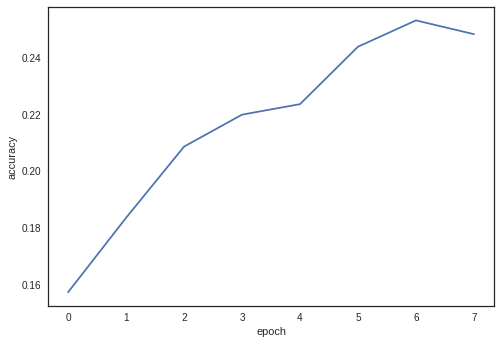

In [36]:
## visualize training process across epochs
# (adapted from lab)

# plot acc vs epoch
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In the final model, there were **68,199 total parameters, all of which are trainable**.

Ultimately, the CNN took only 8 epochs to converge (it was stopped by early_stopping), and produced a **test accuracy of 0.21**. This is a significant improvement over a theoretical random classifier that would produce a test accuracy of 0.14.

**Fine-Tuning of VGG16 Pre-Trained Model:**

*Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc.*

We fine tuned Keras' VGG16 network, generally adapting the code and implementation from the example on the Keras site (adapted from https://keras.io/applications/). The minimum image size requirements for this model were 48x48. Because our image data included images in 32x32 (and none of the pre-trained Keras networks allowed for images less than 48x48), we resized the arrays, effectively adding bits of whitespace to the images.

In the initial phase, the **base model** is loaded, and a fully connected layer and a dense layer are added (as is done in the Keras site example). The base layers are then frozen for initial training.

After the intial model is trained with 5 epochs, the **top eight layers are unfrozen** for fine tuning. The top eight layers were chosen because in the Keras example, they also remove the top two inception blocks. 

The model is then trained again using **early stopping**.

The implmentation of the tuning is below:

In [37]:
# reshape x and y training sets to 48x48
train_x_large = np.resize(train_x, (7000, 3, 48, 48))
train_x_large = train_x_large.reshape(7000, 48, 48, 3)
test_x_large = np.resize(test_x, (len(test_x), 3, 48, 48))
test_x_large = test_x_large.reshape(len(test_x), 48, 48, 3)

In [77]:
## load base model
# (adapted from https://keras.io/applications/)

# load base model
base_model = VGG16(weights = 'imagenet',
                         include_top = False,
                         input_shape = (48, 48, 3))

# global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# fully-connected layer
x = Dense(1024, 
          activation='relu')(x)

# logistic layer
predictions = Dense(7, 
                    activation='softmax')(x)

# create model
model = Model(inputs = base_model.input, 
              outputs = predictions)

# freeze base layers
for layer in base_model.layers:
    layer.trainable = False
    
# summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [75]:
## initially compile and fit model
# (adapted from lab https://keras.io/applications/)

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

history = model.fit(train_x_large, train_y,
                    batch_size = 300,
                    epochs = 5,
                    verbose = 1,
                    validation_data = (test_x_large, test_y))

# print test loss and accuracy
score = model.evaluate(test_x_large, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 2180 samples
Epoch 1/5
7000/7000 [==============================] - 8s - loss: 2.0251 - acc: 0.1913 - val_loss: 2.0325 - val_acc: 0.2789

In [61]:
## print base model layers
# (adapted from lab https://keras.io/applications/)

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_10
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [76]:
## Unfreeze top four layers of model to train
# (adapted from lab https://keras.io/applications/)

for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True
    
## re-compile and fit model
# (adapted from lab https://keras.io/applications/)

model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(lr=0.0001, momentum=0.9),
              metrics = ['accuracy'])

history = model.fit(train_x_large, train_y,
                    batch_size = 300,
                    epochs = 10,
                    callbacks = [early_stopping],
                    verbose = 1,
                    validation_data = (test_x_large, test_y))

# print test loss and accuracy
score = model.evaluate(test_x_large, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 2180 samples
Epoch 1/10
7000/7000 [==============================] - 13s - loss: 1.7091 - acc: 0.2921 - val_loss: 2.1827 - val_acc: 0.1124

Once built, the model produced **532,487 trainable parameters**.

Ultimately, the validation accuracy improved with the fine tuning, however the network was generally overfit with a high descrepancy between the training and testing accuracies and losses.

*Discussion of the results, how much improvement you gained with fine tuning, etc.*

Overall, **the network built from scratch significantly outperformed the pre-trained model**, even after fine tuning. While the fine-tuning did increase the training and test accuracies, it did not improve the validation loss.

One factor in the discrepancy between the networks may be the fact that the images needed to be resized to work with the pre-trained model. This naturally led to slight distortions in the images that were not present for the network built from scratch.

Ultimately, however, the classification abilites of the network built from scratch are promising, given that the network produced a test accuracy roughly 40% greater than that of a random classifier.

*Discussion of at least one additional exploratory idea you pursued*

As an exploratory idea, **we compared the performance of the rms optimizer to the SGD optimizer**. Below we recreate the 'scratch' network, this time using an SGD optimizer:

In [51]:
## model from scratch
# (adapted from lecture, lab and
# https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py)

# empty network model
model = Sequential()


# INPUT LAYER #

# 2D convolution layer
model.add(Conv2D(32, 
                 (3, 3), 
                 padding = 'same',
                 input_shape = train_x.shape[1:],
                 activation = 'relu'))
# max pooling
model.add(MaxPooling2D(pool_size = (2, 2),
                      data_format = 'channels_first'))



# HIDDEN LAYER #

# 2D convolution layer
model.add(Conv2D(64, 
                 (3, 3), 
                 padding = 'same'))
# max pooling
model.add(MaxPooling2D(pool_size = (2, 2),
                       data_format = 'channels_first'))
# dropout
model.add(Dropout(0.2))


# FLATTEN #

model.add(Flatten())


# FC LAYER #

# first regularization
model.add(Dense(64, 
                activation = 'relu'))

# CLASSIFICATION #

# dropout
model.add(Dropout(0.5))
# second regularization
model.add(Dense(7, 
                activation = 'softmax'))

# summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 3, 32, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 16, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 16, 64)         9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                49216     
__________

In [52]:
## control settings, optimizer, compiling, and early stopping
# (adapted from lecture, lab and https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py)

# sgd optimizer
sgd_opt = SGD(lr=0.0001, momentum=0.9)

# compile model
model.compile(loss = 'categorical_crossentropy',
              optimizer = sgd_opt,
              metrics = ['accuracy'])

# early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 2)

# settings
batch_size = 100
epochs = 20
input_shape = (3, 32, 32)

In [53]:
## fit model
# (adapted from lab)

history = model.fit(train_x, train_y,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [early_stopping],
                    verbose = 1,
                    validation_data = (test_x, test_y))

# print test loss and accuracy
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 2226 samples
Epoch 1/20
7000/7000 [==============================] - 1s - loss: 2.0139 - acc: 0.1383 - val_loss: 1.9843 - val_acc: 0.0768
Epoch 2/20
7000/7000 [==============================] - 0s - loss: 1.9850 - acc: 0.1409 - val_loss: 1.9671 - val_acc: 0.0939

Interestingly, **while the test accuracy is higher with the SGD optimizer, the training accuracy is signficantly lower**. The test losses with both optimizers are very similar.